# School Enrolment Trends

**Authored by**:  Pooya Forghani Arani

**Duration**: 60 minutes

**Level**: Intermediate

**Pre-requisite Skills**: Python, Pandas, Matplotlib, NumbPy, Seaborn, Folium


### Scenario

As a government planner, I want to analyse school enrolment trends across Melbourne so that we can plan future schools, allocate resources fairly, and respond to changing population needs in each region more effectively.

### What this use case will teach you

- How to explore and understand real-world school data from Victoria
- How to combine enrolment and location data for analysis
- How to find trends in student numbers over time
- How to use maps and charts to show insights clearly
- How to support planning with data-driven decisions

### Background and Introduction

Understanding school enrolment trends is very important for planning and decision-making in education. In a growing city like Melbourne, the number of students in each area can change quickly due to population growth, new housing developments, or changes in family needs. If enrolment increases in one region, more teachers, classrooms, or even new schools may be needed. On the other hand, if enrolments drop, resources may need to be adjusted. This use case looks at school enrolment data from 2020 to 2024, combined with school location data, to help us see how enrolment has changed over time and across different parts of the city. It includes details for each school such as type (primary, secondary), education sector (government, independent, or Catholic), and location. By analysing this data, we can find out which areas are growing, which sectors are changing, and where the most pressure on school infrastructure might be. This helps government planners, education leaders, and local councils make better choices about funding, resources, and new school developments. It also provides useful insights for parents and communities who want to understand the education landscape in their area. This project uses data analysis and visual tools to make these insights clear.

### Datasets used

**School Locations:**

The 2024 School Locations dataset provides detailed information about where schools are located across Victoria. It includes each school's name, type (such as primary or secondary), education sector, and full address. It also contains geographic coordinates, which allow schools to be shown on a map. This dataset helps with understanding school distribution and planning services based on location and region.

- [2024 School Locations](https://discover.data.vic.gov.au/dataset/school-locations-2024) <br>

**School Enrolments:**

The school enrolment datasets from 2020 to 2024 show how many students were enrolled in each school across Victoria each year. They include enrolment numbers by year level, school type, and education sector such as Government, Catholic, and Independent. This information helps track changes over time and supports better decisions for school planning, funding, and resource allocation.

- [All Schools FTE Enrolments 2024](https://discover.data.vic.gov.au/dataset/all-schools-fte-enrolments-feb-2024-victoria) <br>
- [All Schools FTE Enrolments 2023](https://discover.data.vic.gov.au/dataset/all-schools-fte-enrolments-feb-2023-victoria) <br>
- [All Schools FTE Enrolments 2022](https://discover.data.vic.gov.au/dataset/all-schools-fte-enrolments-feb-2022-victoria) <br>
- [All Schools FTE Enrolments 2021](https://discover.data.vic.gov.au/dataset/all-schools-fte-enrolments-feb-2021-victoria) <br>
- [All Schools FTE Enrolments 2020](https://discover.data.vic.gov.au/dataset/all-schools-fte-enrolments-feb-2020) <br>


### Importing Datasets

In this section, the code loads school location and enrolment data from 2020 to 2024. It cleans and combines multiple CSV files, standardizes column names, handles gender-based data in 2020, and prepares a single dataset for further analysis and visualization using Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.ticker as ticker

# for better display
pd.set_option('display.max_columns', None)

# Direct CSV download URL for school locations
location_url = 'https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv'

# Read CSV directly into DataFrame
location_df = pd.read_csv(location_url, encoding='cp1252')

# Display basic info
print("Location dataset loaded:", location_df.shape)

# List of enrolment CSV URLs
enrolment_urls = [
    "https://www.education.vic.gov.au/Documents/about/research/datavic/dv377_DataVic-AllSchoolsEnrolments-2024.csv",
    "https://www.education.vic.gov.au/Documents/about/research/datavic/dv355-VIC%20All%20Schools%20Enrolments%202023.csv",
    "https://www.education.vic.gov.au/Documents/about/research/datavic/dv335-allschoolsFTEenrolmentsFeb2022.csv",
    "https://www.education.vic.gov.au/Documents/about/research/datavic/dv316-allschoolsFTEenrolmentsFeb2021.csv",
    "https://www.education.vic.gov.au/Documents/about/research/datavic/dv300-allschoolsFTEenrolmentsFeb2020.csv"
]

# Define the simplified final column structure (for consistency)
target_columns = [
    'Education_Sector', 'Entity_Type', 'School_No', 'School_Name', 'School_Type', 'School_Status',
    'Prep Total', 'Year 1 Total', 'Year 2 Total', 'Year 3 Total', 'Year 4 Total', 'Year 5 Total', 'Year 6 Total',
    'Primary Ungraded Total', 'Primary Total',
    'Year 7 Total', 'Year 8 Total', 'Year 9 Total', 'Year 10 Total', 'Year 11 Total', 'Year 12 Total',
    'Secondary Ungraded Total', 'Secondary Total', 'Grand Total', 'Year', 'CENSUS_TYPE'
]

enrolment_dfs = []

for url in enrolment_urls:
    df = pd.read_csv(url, encoding='cp1252')
    
    # Clean column names
    df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
    
    if 'Prep Males Total' in df.columns:
        # It's the 2020 dataset (has male/female columns)

        # Combine male + female columns for total columns
        def combine_cols(df, male_col, female_col, new_col):
            male_series = df[male_col] if male_col in df.columns else pd.Series(0, index=df.index)
            female_series = df[female_col] if female_col in df.columns else pd.Series(0, index=df.index)
            df[new_col] = pd.to_numeric(male_series, errors='coerce').fillna(0) + pd.to_numeric(female_series, errors='coerce').fillna(0)


        # Year-wise aggregation
        years = ['Prep', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5', 'Year 6',
                 'Primary Ungraded', 'Year 7', 'Year 8', 'Year 9', 'Year 10', 'Year 11', 'Year 12', 'Secondary Ungraded']
        
        for y in years:
            combine_cols(df, f'{y} Males Total', f'{y} Females Total', f'{y} Total')

        # Keep only the target columns if they exist
        keep_cols = [col for col in target_columns if col in df.columns]
        df = df[keep_cols]

    else:
        # Other years – already in correct format, just align column names
        df.columns = df.columns.str.replace(' ', ' ', regex=False)  # Ensure consistent spacing
        df = df[[col for col in df.columns if col in target_columns]]  # Keep only expected columns

    # Append cleaned DataFrame
    enrolment_dfs.append(df)

# Combine all years
enrolment_df = pd.concat(enrolment_dfs, ignore_index=True)

# Final cleanup
enrolment_df.columns = enrolment_df.columns.str.strip().str.replace(' ', '_')
print("Combined enrolment dataset shape:", enrolment_df.shape)

Location dataset loaded: (2294, 22)
Combined enrolment dataset shape: (11410, 26)


### Data Cleaning & Preparation

In this section, the code prepares the data for merging by converting school numbers and coordinates to the correct data types. It then filters school locations to include only those in Melbourne and merges them with enrolment data using school names, resulting in a combined dataset with both enrolment and location details.

In [2]:
# Ensure School_No is the same type in both DataFrames
enrolment_df['School_No'] = enrolment_df['School_No'].astype(str)
location_df['School_No'] = location_df['School_No'].astype(str)

location_df['X'] = location_df['X'].astype(float)
location_df['Y'] = location_df['Y'].astype(float)

# Filter location_df to only include rows with 'Melbourne' in Address_Town
melbourne_schools = location_df[location_df['Address_Town'].str.contains('Melbourne', case=False, na=False)]

# Now merge only with filtered Melbourne schools
merged_df = pd.merge(enrolment_df, melbourne_schools[['School_Name', 'X', 'Y', 'LGA_Name']], on='School_Name', how='inner')

# Inspect merged data
merged_df


,Education_Sector,Entity_Type,School_No,School_Name,School_Type,School_Status,Prep_Total,Year_1_Total,Year_2_Total,Year_3_Total,Year_4_Total,Year_5_Total,Year_6_Total,Primary_Ungraded_Total,Primary_Total,Year_7_Total,Year_8_Total,Year_9_Total,Year_10_Total,Year_11_Total,Year_12_Total,Secondary_Ungraded_Total,Secondary_Total,Grand_Total,Year,CENSUS_TYPE,X,Y,LGA_Name
0,Catholic,2,25,Simonds Catholic College,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,71.0,64.0,82.0,65.0,66.0,0.0,400.0,400.0,2024,F,144.95288,-37.80597,Melbourne (C)
1,Catholic,2,98,St Michael’s Primary School,Primary,O,33.0,44.0,25.0,43.0,27.0,31.0,21.0,0.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224.0,2024,F,144.94625,-37.79330,Melbourne (C)
2,Catholic,2,605,St Aloysius College,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,143.0,73.0,54.0,65.0,69.0,0.0,557.0,557.0,2024,F,144.94287,-37.79289,Melbourne (C)
3,Catholic,2,1941,Galilee Regional Catholic Primary School,Primary,O,74.0,52.0,52.0,46.0,46.0,51.0,30.0,0.0,351.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.0,2024,F,144.95481,-37.83616,Port Phillip (C)
4,Catholic,2,2079,St Joseph's,Special,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,90.0,161.0,211.0,177.0,164.0,0.0,836.0,836.0,2024,F,144.95494,-37.80384,Melbourne (C)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Independent,2,1,Wesley College,Pri/Sec,O,104.0,104.0,55.0,129.0,126.0,181.0,181.0,0.0,936.0,364.0,378.0,374.0,377.0,383.0,0.0,0.0,2258.0,3194.0,2020,F,144.98214,-37.84883,Melbourne (C)
81,Independent,2,2016,Ozford College,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,93.0,0.0,0.0,162.0,162.0,2020,F,144.95442,-37.81289,Melbourne (C)
82,Independent,2,2072,Melbourne Grammar School,Pri/Sec,O,79.0,79.0,40.0,101.0,100.0,101.0,100.0,0.0,648.0,179.0,178.0,204.0,205.0,199.0,0.0,0.0,1167.0,1815.0,2020,F,144.97709,-37.83359,Melbourne (C)
83,Independent,2,2111,River Nile School,Special,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,76.0,76.0,2020,F,144.95509,-37.80519,Melbourne (C)


### Descriptive Analysis

#### Total Number of Schools by Sector and Type
The code groups the merged data by education sector and school type, then counts the number of unique schools in each group. It creates a bar chart showing how many schools belong to each type and sector, adds count labels on bars, and improves the chart’s style and readability.

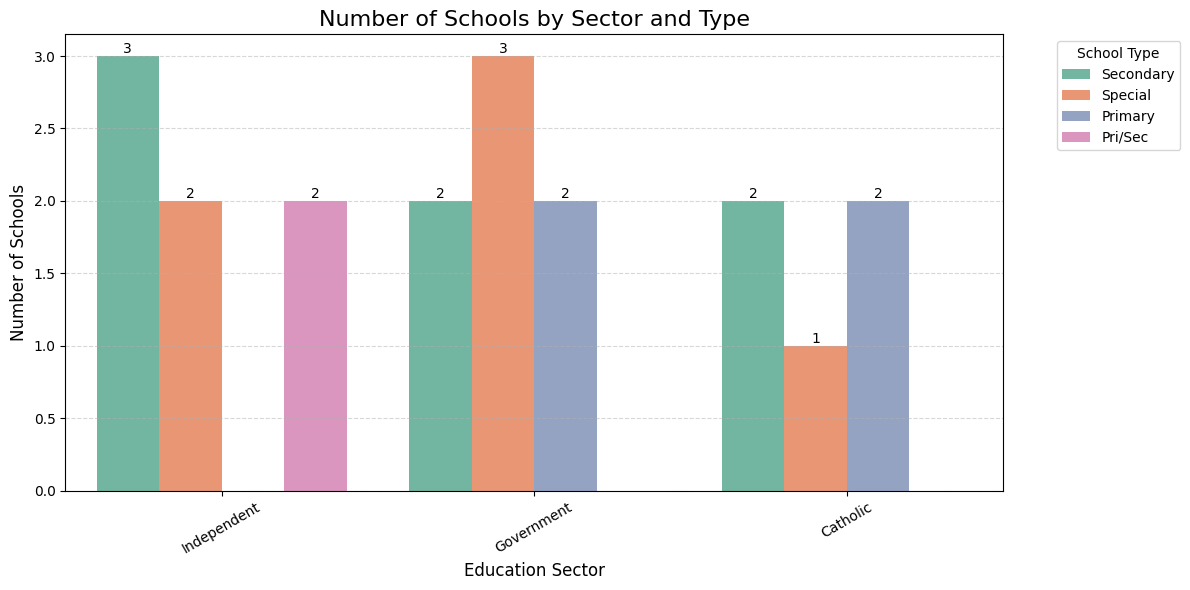

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and count unique schools by Education_Sector and School_Type
school_counts = merged_df.groupby(['Education_Sector', 'School_Type'])['School_No'].nunique().reset_index(name='School_Count')

# Sort data
school_counts = school_counts.sort_values(by='School_Count', ascending=False)

# Plot setup
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=school_counts,
    x='Education_Sector',
    y='School_Count',
    hue='School_Type',
    palette='Set2'
)

# Add count labels on each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10)

# Title and axis labels
plt.title('Number of Schools by Sector and Type', fontsize=16)
plt.xlabel('Education Sector', fontsize=12)
plt.ylabel('Number of Schools', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='School Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#### Average Enrolment Over Time

This code calculates the average enrolment per school type for each year from 2020 to 2024. It then creates a line chart to show trends over time for each school type. The plot includes clear labels, markers, a formatted y-axis, and a legend to compare enrolment across school types.

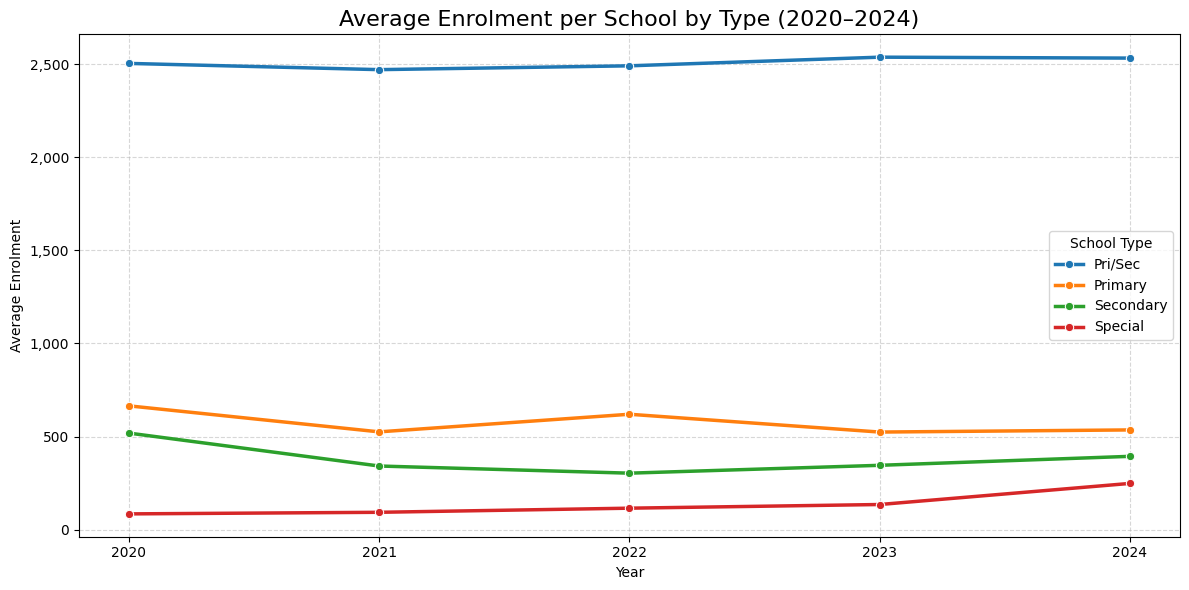

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Group by Year and School_Type, then calculate average enrolment
avg_by_type = merged_df.groupby(['Year', 'School_Type'])['Grand_Total'].mean().reset_index()

# Ensure Year is integer for proper x-axis ticks
avg_by_type['Year'] = avg_by_type['Year'].astype(int)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_by_type, x='Year', y='Grand_Total', hue='School_Type', marker='o', linewidth=2.5)

# Titles and labels
plt.title('Average Enrolment per School by Type (2020–2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Enrolment')
plt.grid(True, linestyle='--', alpha=0.5)

# Format Y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Fix X-axis ticks
plt.xticks(avg_by_type['Year'].unique())

plt.legend(title='School Type')
plt.tight_layout()
plt.show()


#### Mapping Schools in Melbourne

In this part, the code creates an interactive map that shows school locations and enrolment numbers for a selected year. It starts by removing rows with missing coordinates or enrolment values. A dropdown menu lets users pick a year. When a year is selected, the map updates to show only the schools for that year. Each school appears as a circle, and the size of the circle shows how many students are enrolled; bigger bubbles mean more students. When clicked, each bubble shows extra information about the school, like its name, type, sector, and status. A custom legend is also added to the map to show the selected year and the minimum and maximum enrolment values for that year.

In [5]:
geo_df = merged_df.dropna(subset=['X', 'Y', 'Grand_Total'])
year_selector = widgets.Dropdown(
    options=sorted(geo_df['Year'].unique()),
    description='Year:',
    style={'description_width': 'initial'}
)

def draw_map(selected_year):
    clear_output(wait=True)
    display(year_selector)

    # Filter for selected year
    year_df = geo_df[geo_df['Year'] == selected_year]

    # Handle empty case
    if year_df.empty:
        print(f"No data available for year {selected_year}")
        return

    # Calculate bubble scaling
    min_radius = 2
    max_radius = 15
    min_enrol = year_df['Grand_Total'].min()
    max_enrol = year_df['Grand_Total'].max()

    def scale_radius(value):
        return min_radius + (max_radius - min_radius) * (value - min_enrol) / (max_enrol - min_enrol)

    # Create the map
    m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12.5)

    for _, row in year_df.iterrows():
        radius = scale_radius(row['Grand_Total'])
        
        # Create popup content
        popup_html = f"""
        <div style="width: 150px;">
            <strong>{row['School_Name']}</strong><br>
            <b>Enrolment:</b> {int(row['Grand_Total']):,}<br>
            <b>School Type:</b> {row['School_Type']}<br>
            <b>Sector:</b> {row['Education_Sector']}<br>
            <b>Status:</b> {row['School_Status']}
        </div>
        """

        popup = folium.Popup(popup_html, max_width=300, min_width=250)

        folium.CircleMarker(
            location=(row['Y'], row['X']),
            radius=radius,
            popup=popup,
            color='blue',
            fill=True,
            fill_opacity=0.6
        ).add_to(m)

    # Create custom legend HTML
    legend_html = f'''
    <div style="
        position: fixed;
        top: 100px;
        left: 10px;
        width: 220px;
        height: 140px;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:20px;
        padding: 10px;
        box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
        ">
        <b>Enrolment:</b><br>
        Year: {selected_year}<br>
        Min: {int(min_enrol):,} students<br>
        Max: {int(max_enrol):,} students
    </div>
    '''

    m.get_root().html.add_child(folium.Element(legend_html))

    display(m)

    
year_selector.observe(lambda change: draw_map(change['new']) if change['type'] == 'change' and change['name'] == 'value' else None)
draw_map(year_selector.value)

Dropdown(description='Year:', index=4, options=(np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)…

#### Trend Breakdown by Sector

This code creates a line chart to show total school enrolments from 2020 to 2024, grouped by education sector. It uses different colors and markers for each sector to highlight trends over time. The chart includes a title, labels, legend, and formatted axes, making it easy to compare enrolment changes across sectors during the five-year period.

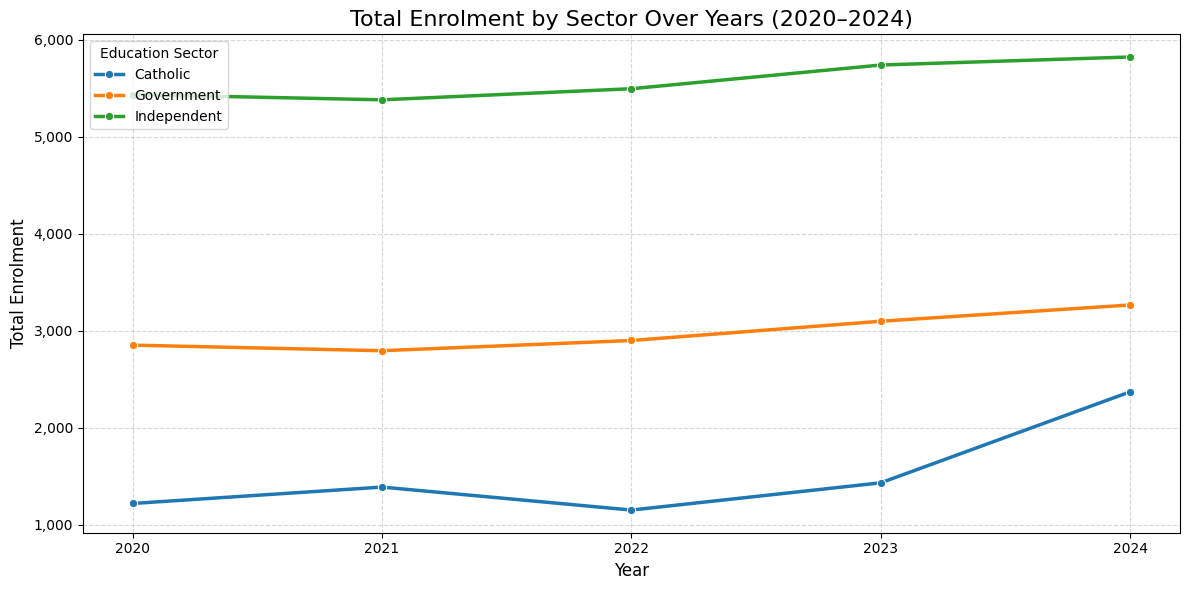

In [6]:
# Group and summarize
sector_trends = merged_df.groupby(['Year', 'Education_Sector'])['Grand_Total'].sum().reset_index()

# Ensure Year is integer
sector_trends['Year'] = sector_trends['Year'].astype(int)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sector_trends,
    x='Year',
    y='Grand_Total',
    hue='Education_Sector',
    marker='o',
    linewidth=2.5,
    palette='tab10'
)

# Title and labels
plt.title('Total Enrolment by Sector Over Years (2020–2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Enrolment', fontsize=12)

# Grid and y-axis formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.xticks(sector_trends['Year'].unique())  # Ensure correct year ticks

# Legend
plt.legend(title='Education Sector', loc='upper left')

plt.tight_layout()
plt.show()


#### LGA-Level Analysis

This code creates a line chart showing enrolment trends from 2020 to 2024 for the top 10 LGAs in Victoria. It first finds the LGAs with the highest total enrolments, then plots each one with a different line. The chart includes a clear title, labels, gridlines, and formatted numbers, making it easy to compare changes over time.

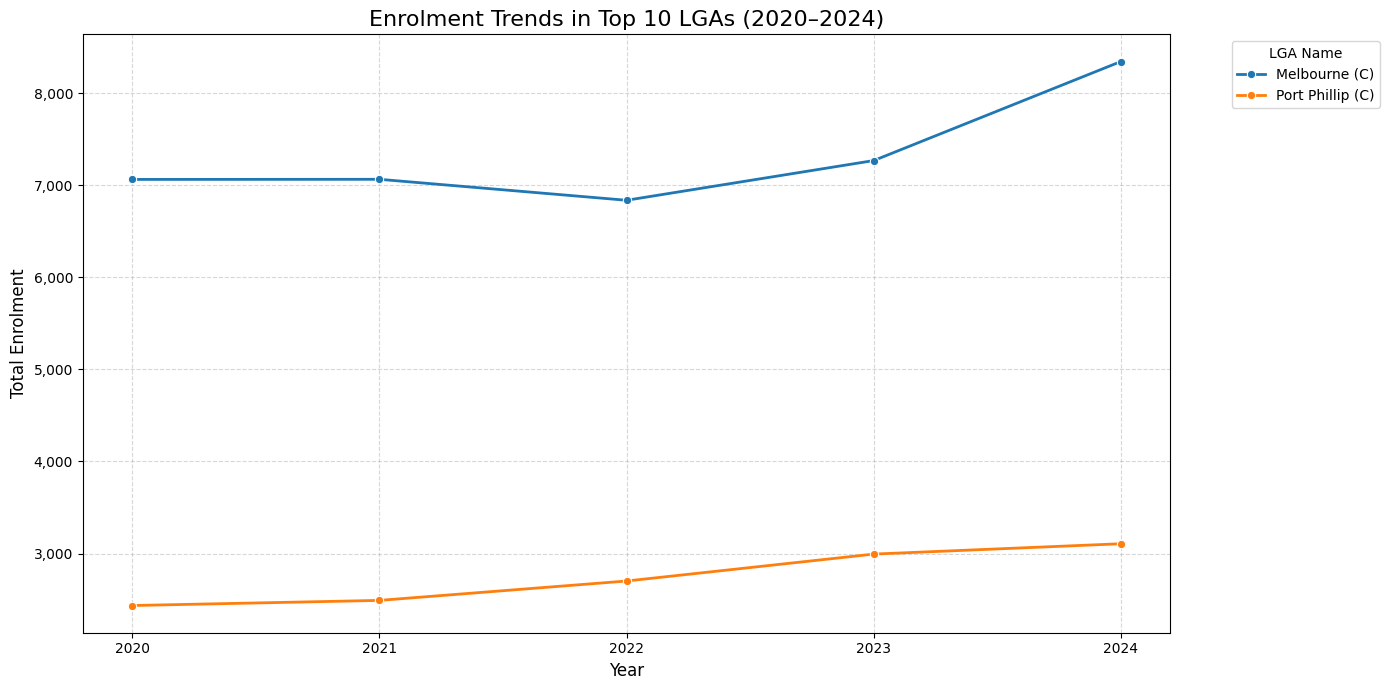

In [7]:
# Group by Year and LGA
lga_enrol = merged_df.groupby(['Year', 'LGA_Name'])['Grand_Total'].sum().reset_index()

# Get top 10 LGAs based on total enrolment across all years
top_lgas = lga_enrol.groupby('LGA_Name')['Grand_Total'].sum().nlargest(10).index

# Filter data to include only top 10 LGAs
filtered_lga = lga_enrol[lga_enrol['LGA_Name'].isin(top_lgas)]

# Ensure Year is integer for correct plotting
filtered_lga['Year'] = filtered_lga['Year'].astype(int)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=filtered_lga,
    x='Year',
    y='Grand_Total',
    hue='LGA_Name',
    marker='o',
    linewidth=2
)

# Titles and labels
plt.title('Enrolment Trends in Top 10 LGAs (2020–2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Enrolment', fontsize=12)
plt.xticks(filtered_lga['Year'].unique())
plt.grid(True, linestyle='--', alpha=0.5)

# Format y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Clean legend
plt.legend(title='LGA Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Conclusion
In this notebook, we explored school enrolment data from 2020 to 2024 and combined it with school location data to find useful insights. We used charts and maps to understand trends across years, sectors, school types, and LGAs. Clustering helped us group schools with similar enrolment patterns. This analysis can support better planning for schools, especially in growing areas. It helps government and education leaders make smart decisions about where to build new schools or provide more resources. The visual tools also make the information easy to understand for the public, parents, and anyone interested in Victoria’s school system.